In [51]:
import pandas as pd
import numpy as np
from copy import copy
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Hàm đọc file mô tả để tiền xử lý

In [52]:
def read_description(path_description='../Data/data_description.txt'):
    cols_description = {}
    col, i, j = 'feature_name', 0, 0
    with open(path_description) as file:
        line = file.readline()
        while len(line) > 0:
            if line[0].isalpha():
                col = line.split(':')[0]
                cols_description[col] = {}
                j = 0
            elif len(line) >= 10:
                keys = line.split()
                if (col == 'MSZoning' and keys[0].lower() == 'c') or (col == 'Exterior1st' and keys[0].lower() == 'wd') \
                        or (col == 'Exterior2nd' and (keys[0].lower() == 'wd' or keys[0].lower() == 'brk')):
                    key = keys[0] + ' ' + keys[1]
                else:
                    key = keys[0]
                cols_description[col][key.lower()] = j
                j += 1
            line = file.readline()
    return cols_description

### Hàm xử lý dữ liệu đầu vào

In [53]:
def process_data(X=pd.DataFrame(), path_description='../Data/data_description.txt'):
    cols_description = read_description(path_description)
    cols = []
    data = copy(X)
    # set value for column is string
    for col in list(data.columns.values):
        if data.dtypes[col] == np.object:
            data[col] = data[col].str.lower().replace(to_replace=cols_description[col].keys(),
                                                      value=cols_description[col].values())
        else:
            cols.append(col)
    # fill cell NaN
    data.fillna(data.median(), inplace=True)
    # normalize data and discrete
    data_number_norm = MinMaxScaler().fit_transform(data[cols].to_numpy())

    data_number_norm = pd.DataFrame(data_number_norm * 10, columns=cols,
                                    index=data.index, dtype=int).round()
    data[cols] = data_number_norm

    return data, cols, data.index

### Hàm lấy ra các features quan trọng dựa trên ma trận tương quan

In [54]:
def important_features(X=pd.DataFrame(), nlargest=10):
    corr = X.corr()['SalePrice'].abs().sort_values(ascending=False)
    features, corr_coeffs = corr.index.values[1:].tolist(), corr.values[1:].tolist()
    return features[:nlargest], corr_coeffs[:nlargest]

In [55]:
def predict_data(model, X=None, path_file_csv='model.csv', index=None):
    X_test = copy(X)
    y = model.predict(X_test)
    result = pd.DataFrame({'Id': index, 'SalePrice': y})
    result.to_csv(path_file_csv, index=False)

In [56]:
if __name__ == '__main__':    
    path_train = 'Data/train.csv'
    path_test = 'Data/test.csv'
    # load data, process data
    X_train = pd.read_csv(path_train, index_col='Id')
    features = list(X_train.columns.values)
    y_train = X_train[features[-1]]
    del X_train[features[-1]]
    X_train, col_number, index_train = process_data(X_train, 'Data/data_description.txt')
    X_train[features[-1]] = pd.DataFrame(y_train)


### Hệ số tương quan

c:\users\dell\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Important Features : ['OverallQual', 'ExterQual', 'GrLivArea', 'KitchenQual', 'GarageCars', 'BsmtQual', 'GarageArea', 'TotalBsmtSF', 'FullBath', '1stFlrSF', 'TotRmsAbvGrd', 'YearRemodAdd', 'YearBuilt', 'GarageFinish', 'Fireplaces', 'MasVnrArea', 'GarageYrBlt', 'HeatingQC', 'BsmtFinSF1', 'Foundation', 'BsmtExposure', '2ndFlrSF', 'WoodDeckSF', 'GarageType', 'SaleCondition', 'LotFrontage', 'HalfBath', 'BsmtFinType1', 'LotShape', 'CentralAir', 'OpenPorchSF', 'Electrical', 'PavedDrive', 'BsmtFullBath', 'RoofStyle']
[0.7976178492717381, 0.6826392416562592, 0.6824519378616748, 0.6595997207286572, 0.6174903415272838, 0.61735598334433, 0.6058181738466871, 0.581633479235594, 0.567327136939889, 0.5590562910740872, 0.5195324965477801, 0.5077575089207901, 0.5065081172256672, 0.4827544109102925, 0.46526062811581786, 0.4507295757715477, 0.45043244268093346, 0.4276487073988049, 0.40778321262588013, 0.38247899119010337, 0.36186283187566154, 0.3404470052014447, 0.3064287138735045, 0.30210546284841194, 0

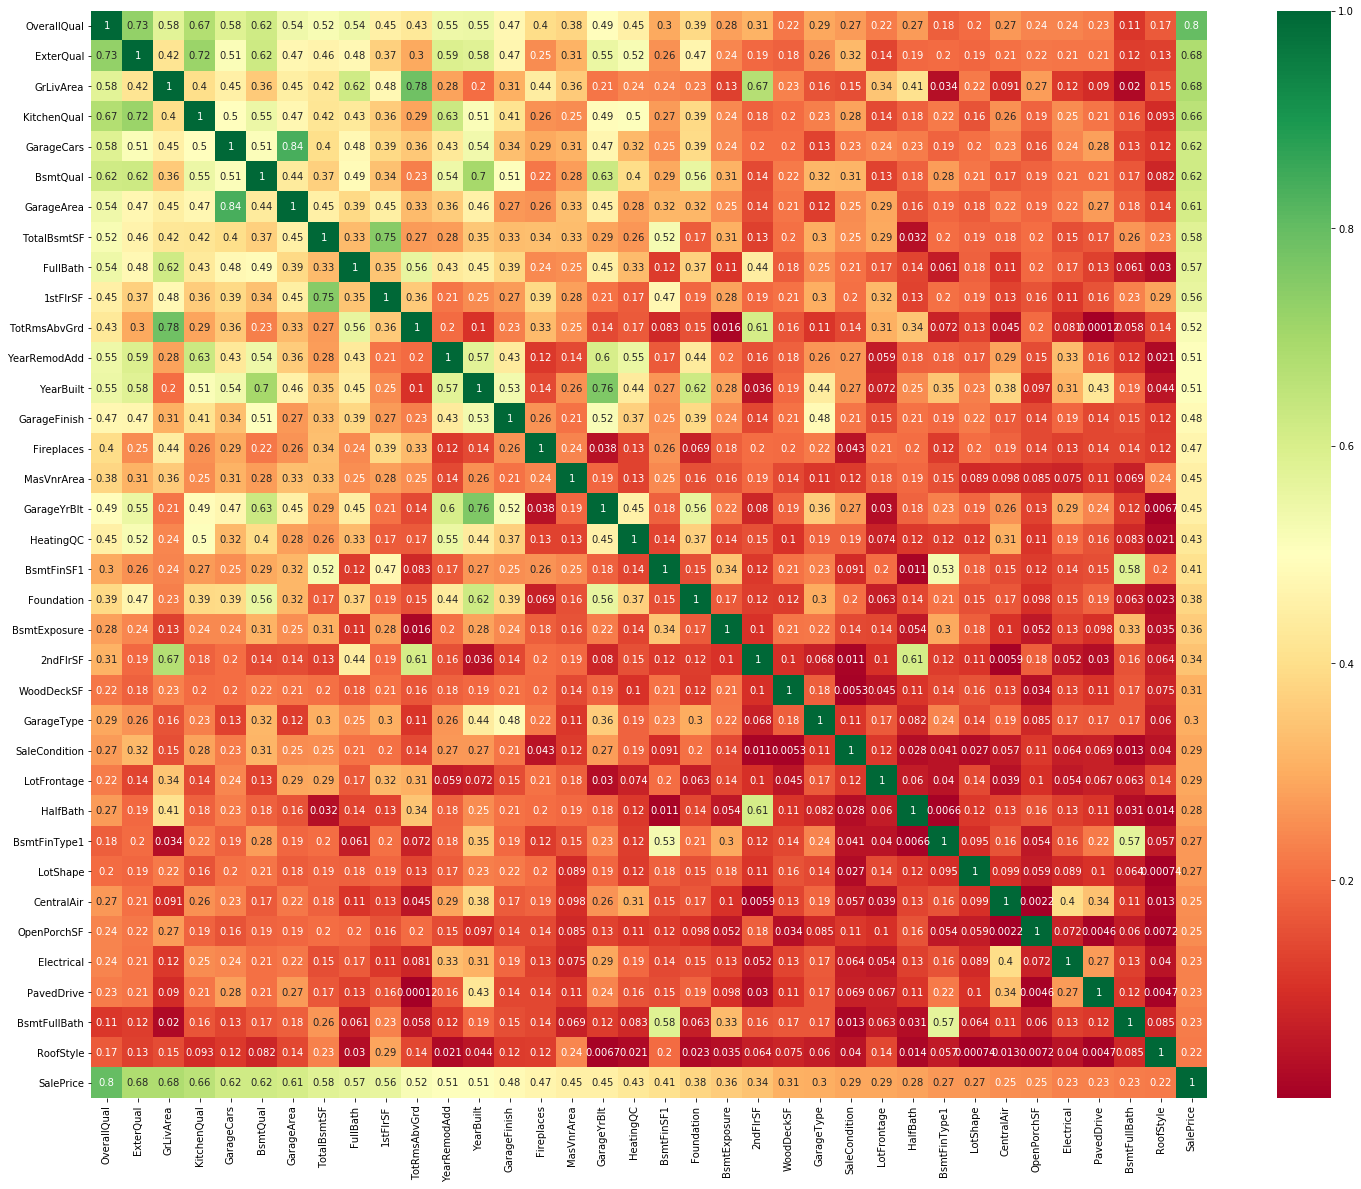

In [58]:
    # get important features
    features, coeff = important_features(X_train, 35)
    X_train_model = X_train[features]
    X_train_model['SalePrice'] = y_train
    print('Important Features :', features)
    print(coeff)
    plt.figure(figsize=(25,20))
    g=sns.heatmap(X_train_model.corr().abs(),annot=True,cmap="RdYlGn")

In [59]:
    features = ['OverallQual', 'GrLivArea', 'KitchenQual', 'GarageCars', 'BsmtQual'
                , 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', 'GarageFinish', 'Fireplaces', 
                'MasVnrArea',  'HeatingQC', 'BsmtFinSF1', 'Foundation', 'BsmtExposure', 'WoodDeckSF',
                'GarageType', 'SaleCondition', 'LotFrontage', 'HalfBath', 'BsmtFinType1', 'LotShape', 'CentralAir', 
                'OpenPorchSF', 'Electrical', 'PavedDrive', 'BsmtFullBath', 'RoofStyle']

In [60]:
    X_train = X_train[features]
    print('Features train :', features)

Features train : ['OverallQual', 'GrLivArea', 'KitchenQual', 'GarageCars', 'BsmtQual', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', 'GarageFinish', 'Fireplaces', 'MasVnrArea', 'HeatingQC', 'BsmtFinSF1', 'Foundation', 'BsmtExposure', 'WoodDeckSF', 'GarageType', 'SaleCondition', 'LotFrontage', 'HalfBath', 'BsmtFinType1', 'LotShape', 'CentralAir', 'OpenPorchSF', 'Electrical', 'PavedDrive', 'BsmtFullBath', 'RoofStyle']


In [61]:


    # Not Scaling, RandomForest and GradientBoosting
    
    # RandomForest
    random_tree = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42, oob_score=True)
    param_grid = [{'n_estimators': np.linspace(50, 500, 10, dtype=int).tolist()}]
    gs_randomforest = GridSearchCV(random_tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1)
    
    gs_randomforest.fit(X_train, y_train)
    
    # print results of GridSearch
    for mean, param in zip(gs_randomforest.cv_results_['mean_test_score'], gs_randomforest.cv_results_['params']):
        print(np.sqrt(-mean), ':', param)
    print('Best params ', gs_randomforest.best_params_)
    random_tree.set_params(n_estimators=gs_randomforest.best_params_['n_estimators'])
    
    random_tree.fit(X_train, y_train)
    y_train_predict = random_tree.predict(X_train)
    print('RandomForest MSE train : ', np.sqrt(mean_squared_error(y_train, y_train_predict)))
    
    #
    # # ----------------------------------------------------------------------------
    #
    gb = GradientBoostingRegressor(n_estimators=500, random_state=42, learning_rate=0.3)
    
    param_grid = [
        {'n_estimators': np.linspace(50, 500, 10, dtype=int).tolist(),
         'learning_rate': np.linspace(0.1, 0.9, 9).tolist()}]
    gs_gb = GridSearchCV(gb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    gs_gb.fit(X_train, y_train)
    
    for mean, param in zip(gs_gb.cv_results_['mean_test_score'], gs_gb.cv_results_['params']):
        print(np.sqrt(-mean), ':', param)
    print('Best params ', gs_gb.best_params_)
    
    gb.set_params(n_estimators=gs_gb.best_params_['n_estimators'], learning_rate=gs_gb.best_params_['learning_rate'])
    gb.fit(X_train, y_train)
    
    y_train_predict_gb = gb.predict(X_train)
    
    print('GradientBoosting MSE train : ', np.sqrt(mean_squared_error(y_train, y_train_predict_gb)))
    #
    # predict data from test.csv
    X_test_real = pd.read_csv(path_test, index_col='Id')
    X_test_real, _, index_test = process_data(X_test_real, 'Data/data_description.txt')
    X_test_real = X_test_real[features]
    print('RandomForest Predict test.csv ...')
    predict_data(random_tree, X_test_real, 'Data/test_random_tree.csv', index_test)
    print('GradientBoosting Predict test.csv ...')
    predict_data(gb, X_test_real, 'Data/test_gradient_boosting.csv', index_test)

32637.56542709837 : {'n_estimators': 50}
31908.622268381696 : {'n_estimators': 100}
31877.692094365964 : {'n_estimators': 150}
31797.043610909066 : {'n_estimators': 200}
31638.84157600635 : {'n_estimators': 250}
31570.39105609418 : {'n_estimators': 300}
31580.91157468764 : {'n_estimators': 350}
31580.89408766624 : {'n_estimators': 400}
31581.64594443921 : {'n_estimators': 450}
31521.862286721847 : {'n_estimators': 500}
Best params  {'n_estimators': 500}
RandomForest MSE train :  11828.257358481147
30814.628689645786 : {'learning_rate': 0.1, 'n_estimators': 50}
30476.81990977337 : {'learning_rate': 0.1, 'n_estimators': 100}
30789.408021302548 : {'learning_rate': 0.1, 'n_estimators': 150}
30878.26607945776 : {'learning_rate': 0.1, 'n_estimators': 200}
30906.545248849023 : {'learning_rate': 0.1, 'n_estimators': 250}
31089.282016656747 : {'learning_rate': 0.1, 'n_estimators': 300}
31115.12069237155 : {'learning_rate': 0.1, 'n_estimators': 350}
31210.925520877372 : {'learning_rate': 0.1, 'n